## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
#fundamental_df = pd.read_csv('tmp_factor.csv').iloc[:,1:]
universe_raw = pd.read_csv('AI_data/factors_AI_108.csv').iloc[:,1:]
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y%m%d')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)
print(universe.shape)

(69262, 9)


In [3]:
universe.columns

Index(['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_atr', 'alpha_010', 'alpha_AI'],
      dtype='object')

In [4]:
# only use from 2022.6 to 2023.4, here from 2022.5 in order to generate risk model from history
universe = universe.loc[universe['trade_date']>=20220501]
universe.columns

Index(['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_atr', 'alpha_010', 'alpha_AI'],
      dtype='object')

### Rescale AI factor

In [5]:
# need to fix excuteed in privious step
def rescale_AI(data):
    feature = 'alpha_AI'
    data[[feature]] = data[[feature]].apply(zscore)
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(), 
                                 np.where(data[feature]<0, data[feature]/-data[feature].min(), 0.))
    return data

universe = universe.groupby('trade_date').apply(rescale_AI)

0.015174810825725827


<AxesSubplot:>

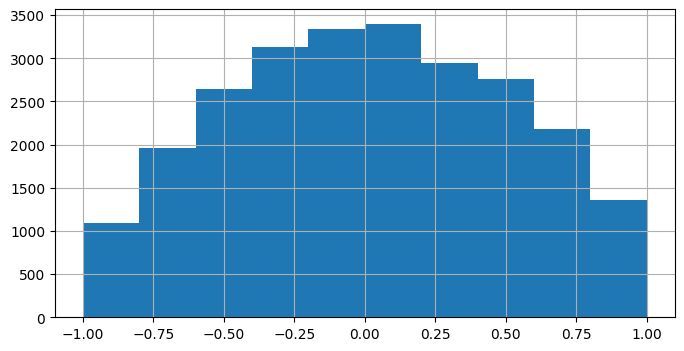

In [6]:
print(universe['alpha_AI'].mean())
universe['alpha_AI'].hist()

### Alignment Tickers
fill data to history by 0 in order to get align ticker marix data each day.

In [7]:
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                # date ts_code trade_date name industry close log-ret  alpha_atr, alpha_010, alpha_AI
                data = [pd.to_datetime(dt, format='%Y%m%d'), ticker, dt, check_df['name'],
                        check_df['industry'], 0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date']) 
    return df

universe = init_holding(universe)

100%|█████████████████████████████████████████| 233/233 [00:02<00:00, 97.30it/s]


### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [8]:
## shif return 5 days
all_factors = universe.copy(deep=True)
all_factors = all_factors.sort_values(by=['date'])
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-5)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date'])
print(universe.shape, all_factors.shape)

(24931, 9) (24931, 10)


In [9]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.15, 0.15)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']==20220601])

alpha_atr   -0.008720
alpha_010   -0.014401
alpha_AI     0.001409
dtype: float64

In [10]:
#all_factors.loc[all_factors['trade_date']>=20220601]

In [11]:
from scipy.stats import zscore
base_field = ['ts_code','trade_date','name', 'industry', 'close', 'log-ret']
alpha_field = ['alpha_atr', 'alpha_010', 'alpha_AI'] 
date_and_code = [ 'trade_date','ts_code', 'returns_2']

calendar = all_factors.trade_date.unique() # int64
alpha_df = all_factors[alpha_field + date_and_code]
facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df['trade_date']==dt])
facret[calendar[-1]]

regression factor returns: 100%|██████████████| 233/233 [00:04<00:00, 55.99it/s]


alpha_atr    0.0
alpha_010    0.0
alpha_AI     0.0
dtype: float64

#### Veiw Factor Returns

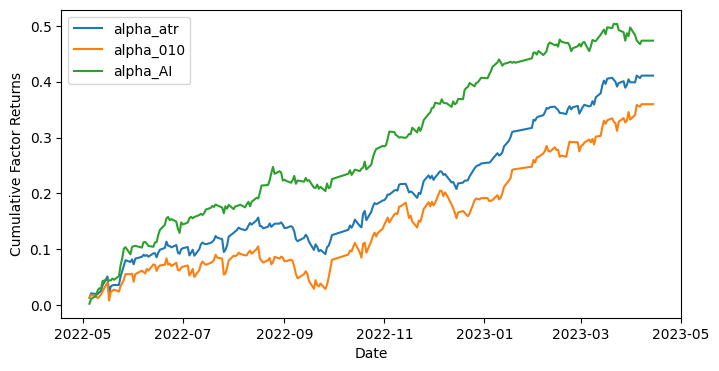

In [12]:
date_list = all_factors.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

### PCA model
We use PCA algorithm to estimate risk

In [13]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=252):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, 
                                            self.factor_returns_, self.factor_betas_, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [14]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 1
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    f = rm.factor_returns_
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, f, rm.idiosyncratic_var_vector

# test
start_time = 20220520
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 11
return date 20220520


ts_code,000411.SZ,000756.SZ,000915.SZ,002322.SZ,002362.SZ,002365.SZ,002380.SZ,002462.SZ,002577.SZ,002605.SZ,...,688230.SH,688244.SH,688259.SH,688314.SH,688317.SH,688358.SH,688579.SH,688589.SH,688655.SH,688799.SH
ts_code,,,,,,,,,,,,,,,,,,,,,
000411.SZ,0.280240,0.108161,0.006802,-0.000126,0.000485,0.055737,0.003166,0.013171,0.005757,0.007432,...,0.003692,0.0,-0.004927,0.003648,0.034976,0.025505,-0.001996,-0.020043,0.012191,0.017124
000756.SZ,0.108161,1.117101,0.045307,-0.000842,0.003232,0.371276,0.021092,0.087734,0.038350,0.049505,...,0.024595,0.0,-0.032821,0.024299,0.232980,0.169893,-0.013299,-0.133512,0.081207,0.114069
000915.SZ,0.006802,0.045307,0.202537,-0.000053,0.000203,0.023347,0.001326,0.005517,0.002412,0.003113,...,0.001547,0.0,-0.002064,0.001528,0.014651,0.010684,-0.000836,-0.008396,0.005107,0.007173
002322.SZ,-0.000126,-0.000842,-0.000053,0.022748,-0.000004,-0.000434,-0.000025,-0.000102,-0.000045,-0.000058,...,-0.000029,0.0,0.000038,-0.000028,-0.000272,-0.000198,0.000016,0.000156,-0.000095,-0.000133
002362.SZ,0.000485,0.003232,0.000203,-0.000004,0.054933,0.001665,0.000095,0.000394,0.000172,0.000222,...,0.000110,0.0,-0.000147,0.000109,0.001045,0.000762,-0.000060,-0.000599,0.000364,0.000512


In [15]:
# check estimate risk at spicified time
h=np.array([1]*107) 
(np.dot(h, variance_i).dot(h.T))** 0.5

14.598939742840278

In [16]:
start_time = 20220520
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.mean(axis=0)]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 11
(23754, 3) (23754, 11)


### Combine Factors

In [18]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code'])
alpha_df['alpha_all'] = 0.5 * alpha_df['alpha_AI'] + 0.4*alpha_df['alpha_atr'] + 0.1*alpha_df['alpha_010']
alpha_df = alpha_df.sort_values(by=['date'])                   
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

1.0 -1.0


### Backtest by Convex Optimization
- use `scipy.optimize.fmin_l_bfgs_b` top optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk rescale weights

In [32]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=5e-3, aversion=.4): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + aversion * (np.dot(h, variance).dot(h.T))**0.05 / 10 \
             + Lambda * abs((h-h0)).sum()
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=5e-3, aversion=.4):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) / 10 \
                + Lambda
        return f_hat
    return grad_func

# bounds means position bounds at each row. Here I only trade for long so that bounds from 0 to 1

#start_time = 20220601
alpha_df['h_privious'] = 0.
positions = {}
calendar = alpha_df.trade_date.unique()

# get parameter
ticker_num = len(alpha_df.index.get_level_values(1).unique())
h0 = [0.] * ticker_num
bounds = [(0,100)] * ticker_num

for dt in calendar:
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
    # convex optimize
    obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
    #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    
    # update optimize holding
    obj_df['h_opt'] = h_optimal
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal

3732.0448440344335 507.5923859339475


<AxesSubplot:>

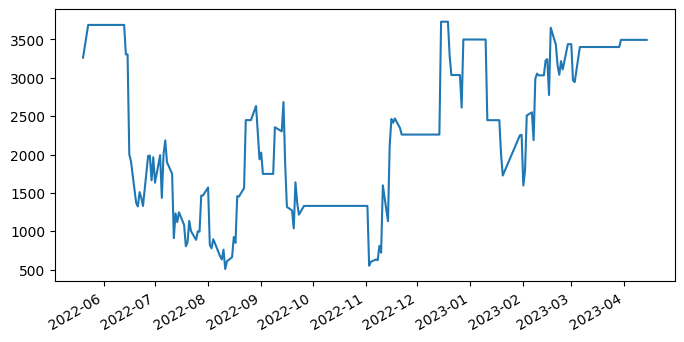

In [33]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
#positions[20230315]['h_opt'].hist()
calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=pd.to_datetime(calendar, format='%Y%m%d')).plot()

### Normalize optimal sum to 1

In [21]:
#for i in positions.keys():
#    positions[i]['h_opt'] = positions[i]['h_opt']/(positions[i]['h_opt'].sum())
#    positions[i]['h_privious'] = positions[i]['h_privious']/(positions[i]['h_privious'].sum())
    #positions[i]['h_opt'] = positions[i]['h_opt']/1500
    #positions[i]['h_privious'] = positions[i]['h_privious']/1500
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

In [22]:
all_positions = []
for dt in list(positions.keys())[3:]:
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))

3897.5165901689184 324.11623498482345


3514.1418113927593


trade_date  name industry     close   log-ret  \
date       ts_code                                                    
2022-06-02 000756.SZ    20220602  新华制药     化学制药  28.79642 -0.033212   
           002365.SZ    20220602  永安药业     化学制药  11.66000 -0.041165   
           002605.SZ    20220602  姚记科技      互联网  15.58478 -0.021734   
           002788.SZ    20220602  鹭燕医药     医药商业   7.62961 -0.001263   
           300109.SZ    20220602   新开源     化工原料  13.86000  0.010152   
           002649.SZ    20220602  博彦科技     软件服务  10.01000  0.008024   
           300531.SZ    20220602   优博讯     软件服务  14.03000  0.005002   
           300363.SZ    20220602  博腾股份     化学制药  65.91000 -0.035620   
           300494.SZ    20220602  盛天网络      互联网  14.21000  0.004231   
           300677.SZ    20220602  英科医疗     医疗保健  22.14946  0.001102   
           300235.SZ    20220602  方直科技     软件服务  10.01000  0.000000   
           300852.SZ    20220602  四会富仕      元器件  33.60000  0.029907   
           300878.SZ    20220602  维康药业      中成药  22.65719 -0.002418   
           301130.SZ    20220602  西点药业     化学制药  41.92166 -0.012757   
           603496.SH    20220602  恒为科技     IT设备  11.23000  0.006253   
           605058.SH    20220602  澳弘电子      元器件  18.34486  0.013496   
           605258.SH    20220602  协和电子      元器件  22.72255  0.037624   
           605398.SH    20220602  新炬网络     软件服务  23.20347  0.019448   
           688163.SH    20220602  赛伦生物     生物制药  26.15176  0.032728   
           688228.SH    20220602   开普云      互联网  33.44000  0.062945   
           688244.SH    20220602  永信至诚     软件服务   0.00000  0.000000   
           688314.SH    20220602  康拓医疗     医疗保健  47.56000  0.035963   
           688589.SH    20220602   力合微      半导体  41.81000  0.067781   
           688655.SH    20220602   迅捷兴      元器件  12.90643  0.073515   
           603508.SH    20220602  思维列控     软件服务  13.09956  0.020565   

                      alpha_atr  alpha_010  alpha_AI  residual  alpha_all  \
date       ts_code                                                          
2022-06-02 000756.SZ  -1.000000  -0.133733 -1.000000  1.265536  -0.913373   
           002365.SZ   0.863512   0.845592 -0.078331  0.128674   0.390798   
           002605.SZ   0.368519   0.902158  0.299919  0.166008   0.387583   
           002788.SZ   1.000000   1.000000  0.202993  0.038772   0.601497   
           300109.SZ   0.000000   0.000000 -0.170402  0.113237  -0.085201   
           002649.SZ   0.859683   0.868245  1.000000  0.011434   0.930698   
           300531.SZ   0.309322   0.562264  0.034262  0.093490   0.197086   
           300363.SZ  -0.747295  -1.000000 -0.233991  0.142290  -0.515914   
           300494.SZ   1.000000   1.000000  0.294146  0.045944   0.647073   
           300677.SZ   0.871498   0.785609  0.523765  0.016325   0.689043   
           300235.SZ   0.675225   0.868245  0.258392  0.028199   0.486111   
           300852.SZ  -0.742734  -1.000000 -0.058307  0.057429  -0.426247   
           300878.SZ   0.530155   0.341601  0.347303  0.009012   0.419874   
           301130.SZ  -0.458751  -0.286824 -0.805080  0.619832  -0.614723   
           603496.SH   0.855772   0.501416  0.545563  0.015155   0.665232   
           605058.SH   0.623050   0.402612  0.843584  0.010530   0.711273   
           605258.SH  -0.228782  -0.047602 -0.135239  0.022731  -0.163892   
           605398.SH   0.102801  -0.049634  0.185311  0.008669   0.128813   
           688163.SH   0.285299   0.824273 -0.584090  0.066514  -0.095498   
           688228.SH  -1.000000  -0.468300  0.069458  0.070049  -0.412101   
           688244.SH   0.000000   0.000000  0.000000  0.000000   0.000000   
           688314.SH  -0.819362  -1.000000 -0.193850  0.191062  -0.524670   
           688589.SH   0.728007   0.817928  0.251683  0.120820   0.498837   
           688655.SH   0.510888   0.861362  0.311988  0.099209   0.446486   
           603508.SH   0.787701   0.663223  0.476024  0.007084   0.619415   

                      h_

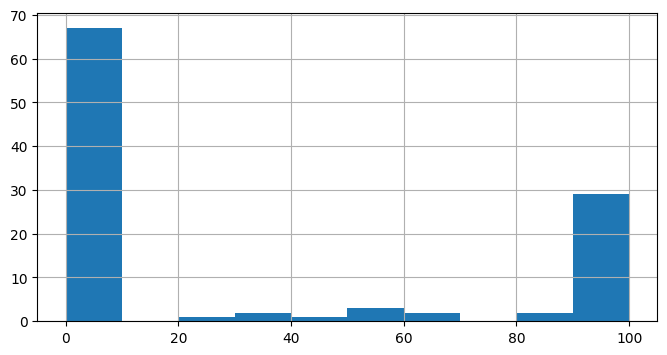

In [23]:
positions[20220602]['h_opt'].hist()
print(positions[20220602].loc[positions[20220602]['h_opt']>0]['h_opt'].sum())
positions[20220602].loc[positions[20220602]['h_opt']==100]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

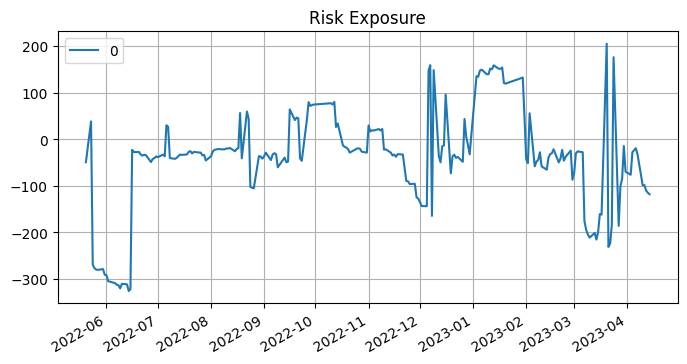

In [24]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### Alpha Exposure

<AxesSubplot:>

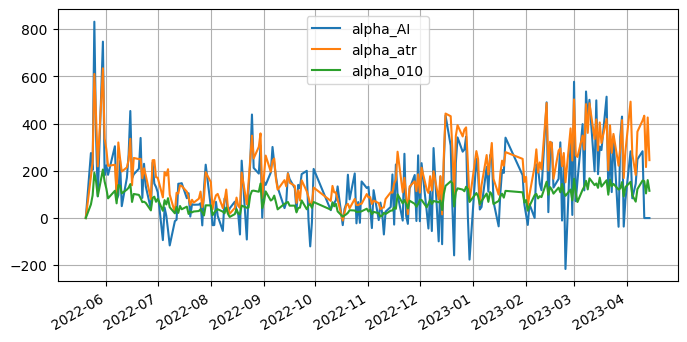

In [25]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code','alpha_AI', 'alpha_atr', 'alpha_010', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    # alpha_df['alpha_all'] = 0.7 * alpha_df['alpha_AI'] + 0.3*alpha_df['alpha_149'] + 0.1*alpha_df['alpha_010']
    B_alpha = B_alpha * [[0.6, 0.3, 0.1]] #* len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha_AI', 'alpha_atr', 'alpha_010'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
alpha_exposure_df.plot(grid=True)

103.83085156974612


<AxesSubplot:>

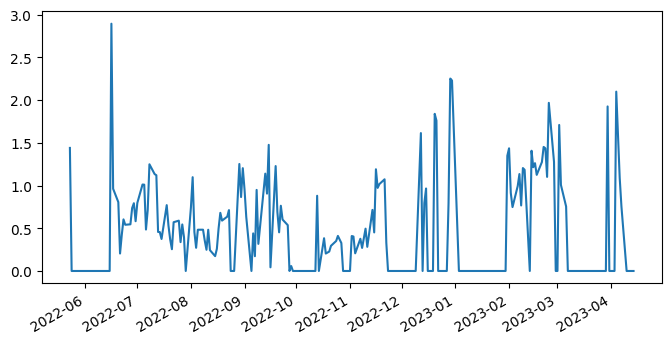

In [26]:
transaction_costs = []
Lambda = 1e-3
for i in range(1,len(h_optimal_list)):
    tmp_change = np.where((h_optimal_list[i] - h_privious_list[i])<0, h_privious_list[i] - h_optimal_list[i], 0)
    #costs = sum(np.dot(tmp_change.values**2, Lambda))
    costs = Lambda * tmp_change.sum()
    transaction_costs.append(costs)
print(sum(transaction_costs))
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d')).plot()

### Profit-and-Loss (PnL)

2023-04-10 00:00:00


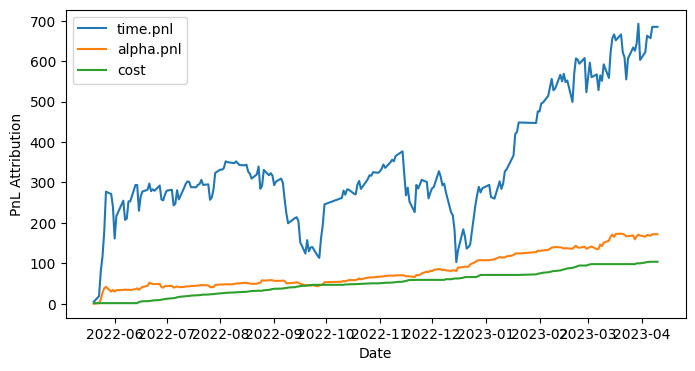

In [27]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d')).iloc[:-4,:]
    calendar = all_factors.trade_date.unique()[:-4]
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        #fr = facret[dt][[0,2,5]]
        fr = facret[dt].loc[['alpha_AI','alpha_atr', 'alpha_010']]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        #df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        df.at[time_i,"cost"] = transaction_costs[ii]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()